In [0]:
#import key packages

from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np
random.seed(2021)
import scipy.stats as sts
from scipy.stats import norm
from copy import deepcopy
from tabulate import tabulate

### **COVID-19 Class**

In [0]:
# The number of days we are simulating for
days = 75 

# new class for simulation
class Covid19:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size = 2000, infect_rate = 0.4, random_interaction = 0.1, \
                 days_symp = 7, days_symp_std = 2, hospital_admit = 0.6, quarantine_noti = 0.8,\
                 quarantine_noti_2 = 0.4, neighbor_rate = 0.2, num_new = 2, second_track = False, \
                 social_distancing = False, quarantine_infect_rate = 0.05, mass_testing = False, \
                 mass_testing_rate = 0.05, false_positive = 0.01, false_negative = 0.01, first_day = np.inf,\
                 setting_mass_test = 6, setting_social_distancing = 2, setting_second_track = 1):
        '''
        Inputs:

                network_size: number of nodes
                infect_rate: the chance of infecting others while interacting
                random_interaction: the chance of a person having random interactions
                days_symp: mean of number of days until a person show symptoms
                days_symp_std: standard deviation of number of days until a person show symptoms
                hospital_admit: the probability of being admitted to the hospital with symptoms
                quarantine_noti: % of F1 got quarantine
                quarantine_noti_2: % of F2 got quarantine
                neighbor_rate: how many people a node interact with
                num_new: initial cases
                second_track: boolean: if F2 tracking is implemented
                quarantine_infect_rate: change of infecting others while being in quarantine
                social_distancing: boolean: if social distancing is implemented
                false_positive: testing false positive rate
                false_negative: testing false negative rate
                mass_testing: boolean: is mass testing is implemented
                mass_testing_rate: % of population got tested randomly
                first_day: track the first day a case is detected
                setting_mass_test: time to set up mass testing
                setting_social_distancing: time to set up social distancing
                setting_second_track: time to set up F2 tracking
            
        '''
        self.network_size = network_size
        self.infect_rate = infect_rate
        self.random_interaction = random_interaction
        self.days_symp = days_symp
        self.days_symp_std = days_symp_std
        self.hospital_admit = hospital_admit
        self.quarantine_noti = quarantine_noti
        self.quarantine_noti_2 = quarantine_noti_2
        # how many friends u contact with in your neighbor
        self.neighbor_rate = neighbor_rate
        self.num_new = num_new
        self.second_track = second_track
        self.quarantine_infect_rate = quarantine_infect_rate
        self.social_distancing = social_distancing
        self.false_positive = false_positive
        self.false_negative = false_negative
        self.mass_testing = mass_testing
        self.mass_testing_rate = mass_testing_rate
        self.first_day = first_day
        self.setting_mass_test = setting_mass_test
        self.setting_social_distancing = setting_social_distancing
        self.setting_second_track = setting_second_track


    def initialize(self, sim):
        # copy the network from the SocialDynamicSimulation
        self.graph = deepcopy(sim.graph)
        for node in self.graph.nodes:
          # infected or not
          self.graph.nodes[node]['status'] = 0
          # the value of personal immune system
          self.graph.nodes[node]['immune'] = round(np.random.normal(self.days_symp, self.days_symp_std))
          # =1 if detected with corona virus
          self.graph.nodes[node]['hospital'] = 0
          # =1 if quarantine
          self.graph.nodes[node]["quarantine"] = 0

        # getting random nodes to start the pandemics
        affected = random.sample(list(self.graph.nodes), self.num_new)

        # having a set to track who is infected
        self.list_affected = set(affected)
        # a set to track who is hospitalized
        self.list_hospital = set()
        # a set of all nodes
        self.all_nodes = set([n for n in self.graph.nodes])
        
        # start the pandemic
        for affect in affected:
          self.graph.nodes[affect]['status'] = 1
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0


    def update(self):
      # if mass testing and the set up time is done: 
      # self.first_day + self.setting_mass_test is the time to prepare mass testing
      if self.mass_testing == True and self.step > self.first_day + self.setting_mass_test:
        # only test those not hospitalized
        remain = np.setdiff1d(self.list_hospital, self.all_nodes)

        # get random number of population to be tested
        test = random.sample(list(remain), int(self.mass_testing_rate*len(remain)))
        
        # analyze results of tests
        for tested in test:
          # infected -> hospitalized
          if self.graph.nodes[tested]["infected"] == 1:
            self.graph.nodes[tested]["hospital"] = 1
            # false negative rate
            if random.random() < false_negative:
              self.graph.nodes[tested]["hospital"] = 0
              pass
            # if hospitalized then quarantine
            self.graph.nodes[tested]['quarantine'] = 1
          
          # if not infected
          else:
            # if false positive -> hospitalized
            if random.random() < false_positive:
              self.graph.nodes[tested]["hospital"] = 1
              self.graph.nodes[tested]['quarantine'] = 1

      # new is the set for newly infected case
      new = set()
      for node in self.list_affected:
        # immune credit decreases everyday: count down till symptoms
        self.graph.nodes[node]['immune'] -= 1

        # symptoms show and start going to hospital
        if (self.graph.nodes[node]['immune'] <= 0 and random.random() < self.hospital_admit) or self.graph.nodes[node]['hospital'] == 1:
          # admitted
          self.graph.nodes[node]['hospital'] = 1

          # check if this is first case -> assign the first day a new value
          if len(self.list_hospital) == 0:
            self.first_day = self.step

          # list of hospitalized
          self.list_hospital.add(node)
          self.graph.nodes[node]['quarantine'] = 1

          # cut all connections and the F1 has "quarantine_noti = .8" chance to be quarantined
          neighbor_list = [n for n in self.graph.neighbors(node)]
          for neighbor in neighbor_list:
            # cut connections
            self.graph.remove_edge(node, neighbor)

            # F1 has "quarantine_noti = .8" chance to be quarantined
            if random.random() < self.quarantine_noti:
              self.graph.nodes[neighbor]["quarantine"] = 1

              # if F2 track and the set up time is done: 
              # self.first_day + self.setting_second_track is the time to prepare F2 track
              if self.second_track == True and self.step > self.first_day + self.setting_second_track :
                neighbor_of_neighbor = [n for n in self.graph.neighbors(neighbor)]
                # F2 has "quarantine_noti = .4" chance to be quarantined
                for neighbor_2 in neighbor_of_neighbor:
                  if random.random() < self.quarantine_noti_2:
                    self.graph.nodes[neighbor_2]["quarantine"] = 1
          # if hospitalized -> no more interactions
          pass


        # get the weight for the edge --> only contact with the top 10% highly weighted + and sometime random people
        neighbor_list = [n for n in self.graph.neighbors(node)]
        neighbor_weight = []
        for neighbor in neighbor_list: 
          neighbor_weight.append(self.graph.get_edge_data(node, neighbor)["weight"])
        
        # sort the weight 
        sorted_neighbor_list = [x for _,x in sorted(zip(neighbor_weight, neighbor_list))]

        # if quarantine, then only take top 2 closest
        if self.graph.nodes[node]["quarantine"] == 1 and sorted_neighbor_list != []:
          currents = sorted_neighbor_list[-2:]
          for current in currents:
            # infect rate if in quarantine (=0.05)
            if random.random() < self.quarantine_infect_rate and self.graph.nodes[current]['status'] != 1:
              self.graph.nodes[current]['status'] = 1
              new.add(current)


        else:
          # if social distancing and the set up time is done: 
          # self.first_day + self.setting_social_distancing is the time to prepare social distancing
          if self.social_distancing == True and self.step > self.first_day + self.setting_social_distancing:
            # only interact with the closest people
            people = random.randint(1, 2)
            currents = sorted_neighbor_list[-people:]

          # if not social distancing
          else: 
            # interact with "neighbor_rate = 0.2" of its connections
            currents = sorted_neighbor_list[int(np.floor((1-self.neighbor_rate)*len(neighbor_list))):]

          # random interactions
          if random.random() < self.random_interaction and sorted_neighbor_list != []:
            currents.append(random.sample(sorted_neighbor_list, 1)[0])

          # for those interacted with the infected people, having a infect_rate = 0.4 chance of being infected
          for current in currents:
            # being infected: having a infect_rate = 0.4 chance of being infected
            if random.random() < self.infect_rate and self.graph.nodes[current]['status'] != 1:
              self.graph.nodes[current]['status'] = 1
              new.add(current)

      # update the infected list
      self.list_affected = self.list_affected.union(new)
      self.step += 1
    
    def observe(self):
      '''
      Draw the state of the network with which topic each node is most prefer
      '''
      self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
      plt.figure(figsize=(10,10))
      plt.clf()
      # all the nodes and get the infected status
      nx.draw(
          self.graph, pos=self.layout, with_labels=True,
          node_color = [self.graph.nodes[i]["status"] for i in self.graph.nodes],
          edge_color = [self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
          edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
          alpha=0.7, vmin=0, vmax=1)
      plt.title('Step: ' + str(self.step))
      plt.show()

    # number of infected cases
    def calculate(self):
      return np.mean([self.graph.nodes[i]["status"] for i in self.graph.nodes])

    # number of detected cases
    def calculate_hospital(self): 
      return np.mean([self.graph.nodes[i]["hospital"] for i in self.graph.nodes])

### **Social Dynamic Class**

In [0]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=2000, alpha=0.05, beta=0.3, gamma=4, alpha_std = 0.01, beta_std=0.05, gamma_std=1, num_opinion = 3):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.05. This has a standard deviation: alpha_std. Default: 0.01

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.
               This has a standard deviation: abeta_std. Default: 0.05

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
               This has a standard deviation: alpha_std. Default: 1

            num_opinion: number of opinions (integer)
            
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.alpha_std = alpha_std
        self.beta_std = beta_std
        self.gamma_std = gamma_std
        self.num_opinion = num_opinion

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.barabasi_albert_graph(self.network_size, 5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
            # generate random values from a normal distribution
            self.graph.edges[edge]['beta'] = norm.rvs(self.beta, self.beta_std, size = 1)[0]
            self.graph.edges[edge]['gamma'] = norm.rvs(self.gamma, self.gamma_std, size = 1)[0]
        for node in self.graph.nodes:
            # an array of opinion values
            self.graph.nodes[node]['opinion'] = [random.randint(0, 1) for _ in range(self.num_opinion)]
            # generate random values from a normal distribution
            self.graph.nodes[node]['alpha'] = norm.rvs(self.alpha, self.alpha_std, size = self.num_opinion)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe_fav_topic(self):
        '''
        Draw the state of the network with which topic each node is most prefer
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        # all the nodes and get the max opinion
        master_list = np.array([list(self.graph.nodes[i]['opinion']).index(max(self.graph.nodes[i]['opinion'])) for i in self.graph.nodes])
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color = master_list,
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=self.num_opinion - 1)
        plt.title('Favorite topic discussion. Step: ' + str(self.step))
        
        # print the percentage preference
        for i in range(self.num_opinion):
          print("% likes topic", i, ":", np.mean(master_list == i)*100)
        plt.show()

    def observe_topic(self, topic):
        '''
        Draw the state of the network for each topic
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            # get the topic value for each node
            node_color=[self.graph.nodes[i]['opinion'][topic] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Topic ' + str(topic) +  '. Step: ' + str(self.step))
        plt.show()

    def update(self):
        if random.uniform(0, 1) < 0.05:
            # Create a new edge with 1-sigmoid(opinion difference in selected topic)
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            opinions = [self.graph.nodes[n]['opinion'] for n in new_edge]

            # choose random topic
            topic = random.randint(0, self.num_opinion - 1)
            new_weight = abs(np.array(opinions[0]) - np.array(opinions[1]))[topic]
            new_weight = 1 - (1/(1 + np.exp(-new_weight)))
            self.graph.add_edge(new_edge[0], new_edge[1], weight = new_weight, 
                                beta = norm.rvs(self.beta, self.beta_std, size = 1)[0], 
                                gamma = norm.rvs(self.gamma, self.gamma_std, size = 1)[0])
            
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            # select topic
            topic = random.randint(0, self.num_opinion - 1)
            # conservativeness of the topic
            topic_pref = 10**(-topic)
            for i in [0, 1]:
                # update the node with the topic_preference value
                self.graph.nodes[edge[i]]['opinion'][topic] = (
                    opinions[i][topic] + topic_pref * self.graph.nodes[edge[i]]['alpha'][topic] * weight * (opinions[1-i][topic] - opinions[i][topic]))
            
            self.graph.edges[edge]['weight'] = (
                weight +
                self.graph.edges[edge]['beta'] * weight * (1-weight) *
                (1 - self.graph.edges[edge]['gamma'] * abs(opinions[0][topic] - opinions[1][topic])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

### **Test the model on single simulation**

In [0]:
# function to run the Covid simulations for 75 days and calculate the infect and detected cases
def run_sim(sim, model, days = days, plot = False):
    sim.initialize(model)
    if plot: 
      sim.observe()
    track = []
    track_hospital = []
    for k in range(days):
      sim.update()
      track.append(sim.calculate())
      track_hospital.append(sim.calculate_hospital())
    if plot:
      sim.observe()
    return track, track_hospital

% likes topic 0 : 31.45
% likes topic 1 : 29.15
% likes topic 2 : 39.4


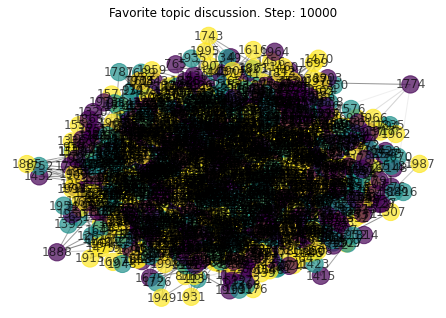

In [5]:
# simulate: initialize the network for the covid19
model = SocialDynamicsSimulation()
model.initialize()

for i in range(10000):
  model.update()
model.observe_fav_topic()

#### **Group 0: social_distancing = False, second_track = False, mass_testing = False**

social_distancing = False, second_track = False, mass_testing = False


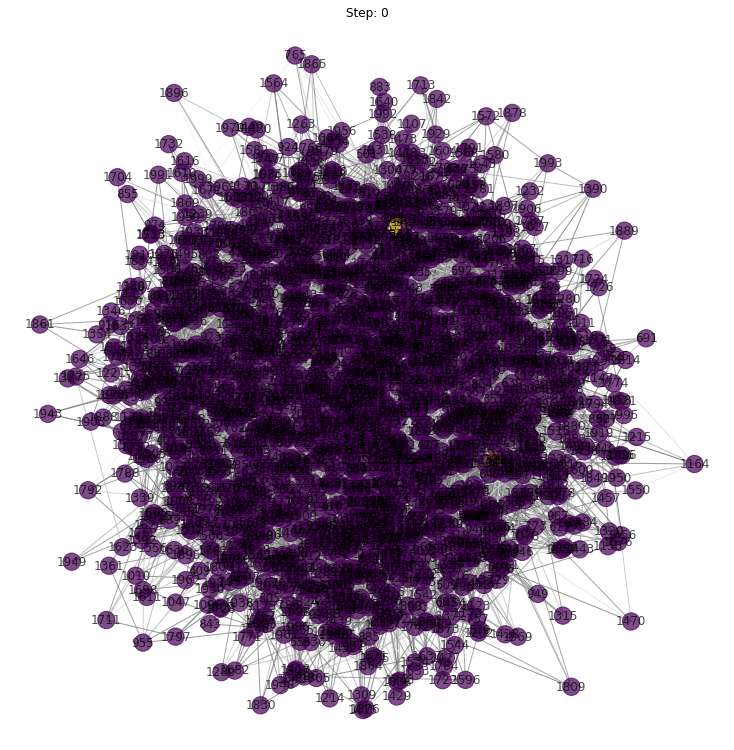

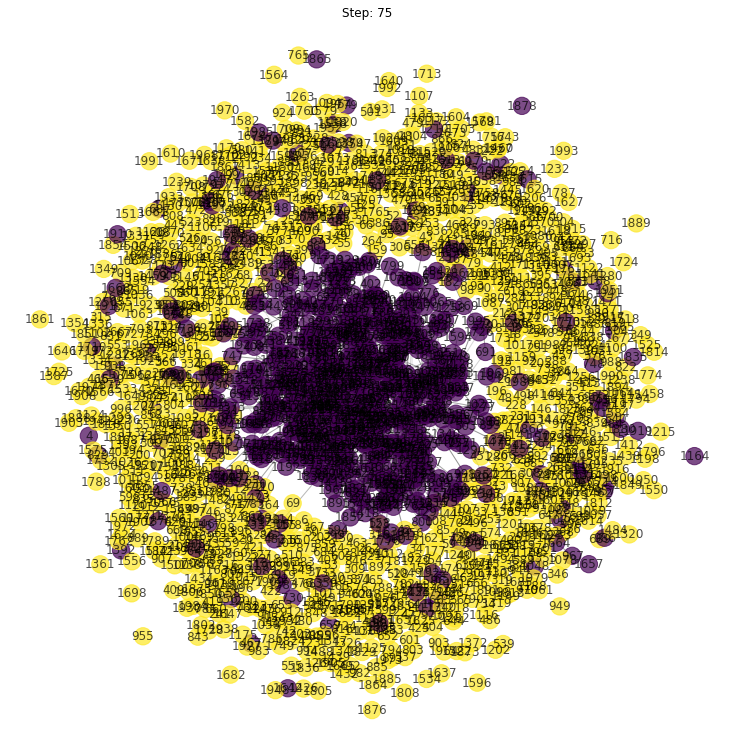

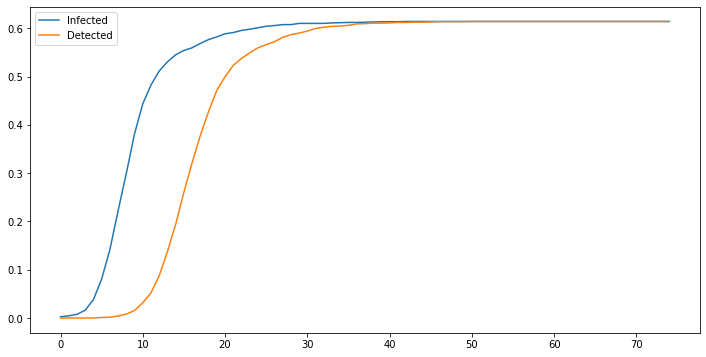

In [6]:
# simulate the covid 19 spread and track its progress
print("social_distancing = False, second_track = False, mass_testing = False")
sim = Covid19(social_distancing = False, second_track = False, mass_testing = False)
track, track_hospital = run_sim(sim, model, plot = True)

plt.figure(figsize = (12,6))
plt.plot(range(days), track, label = "Infected")
plt.plot(range(days), track_hospital, label = "Detected")
plt.legend()
plt.show()

#### **Group 1: social_distancing = False, second_track = False, mass_testing = True**

social_distancing = False, second_track = False, mass_testing = True


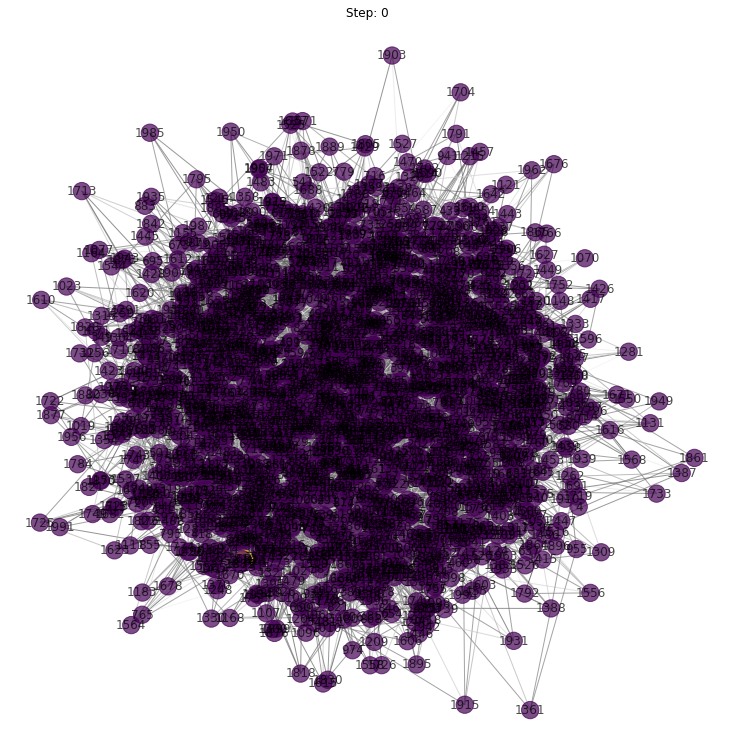

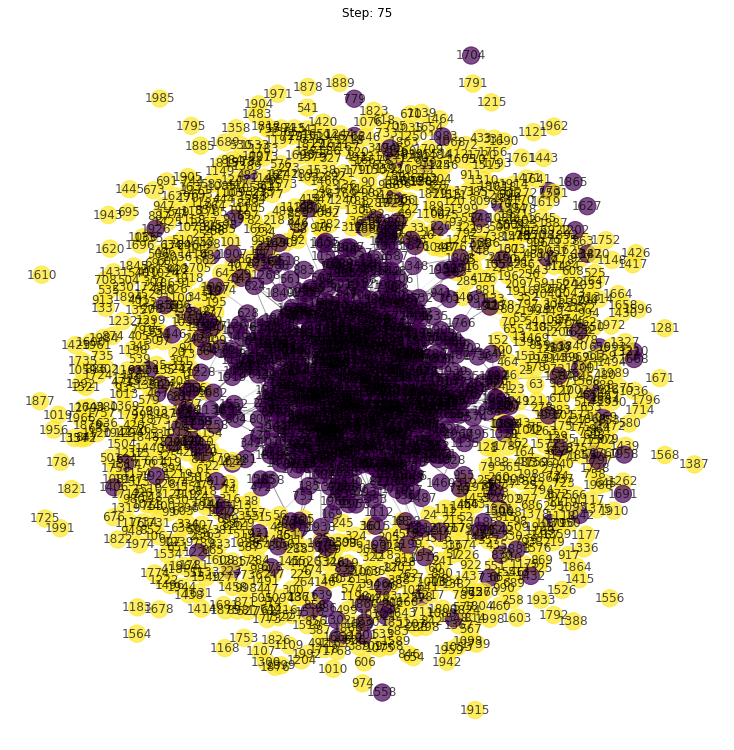

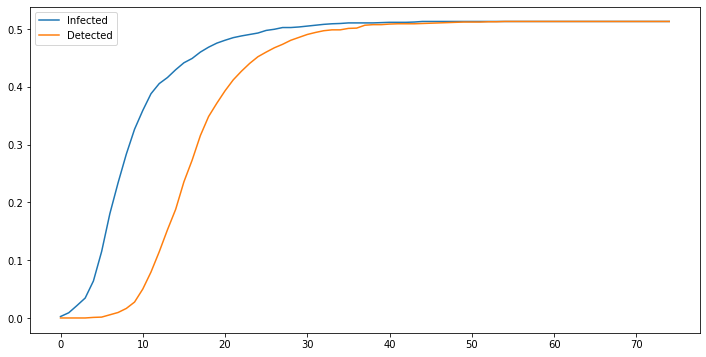

In [7]:
# simulate the covid 19 spread and track its progress
print("social_distancing = False, second_track = False, mass_testing = True")
sim = Covid19(social_distancing = False, second_track = False, mass_testing = True)
track, track_hospital = run_sim(sim, model, plot = True)

plt.figure(figsize = (12,6))
plt.plot(range(days), track, label = "Infected")
plt.plot(range(days), track_hospital, label = "Detected")
plt.legend()
plt.show()

#### **Group 2: social_distancing = False, second_track = True, mass_testing = False**

social_distancing = False, second_track = True, mass_testing = False


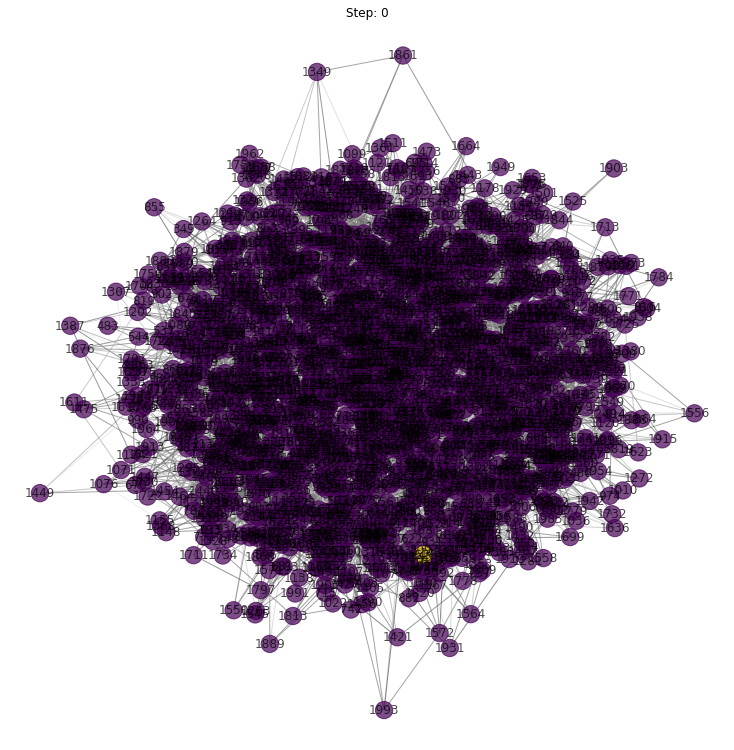

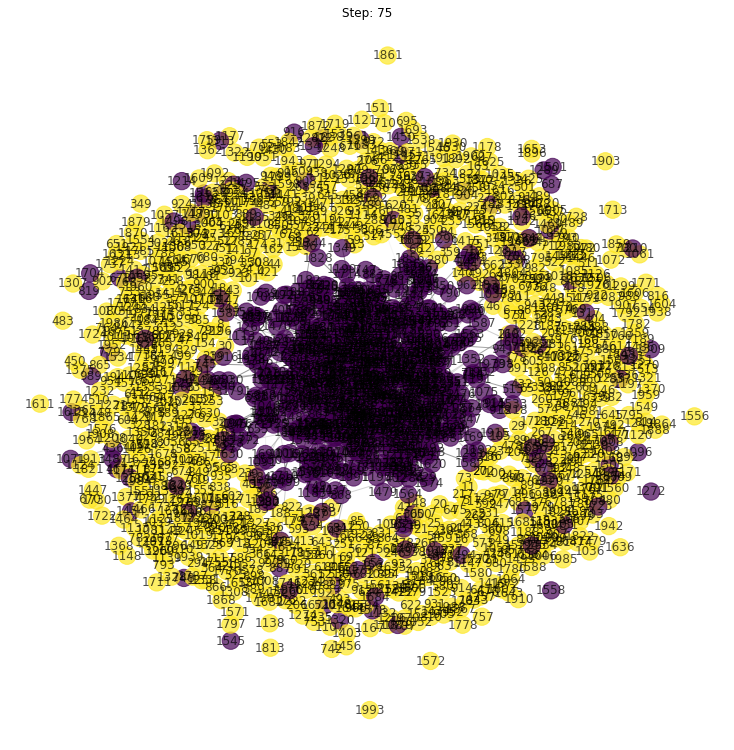

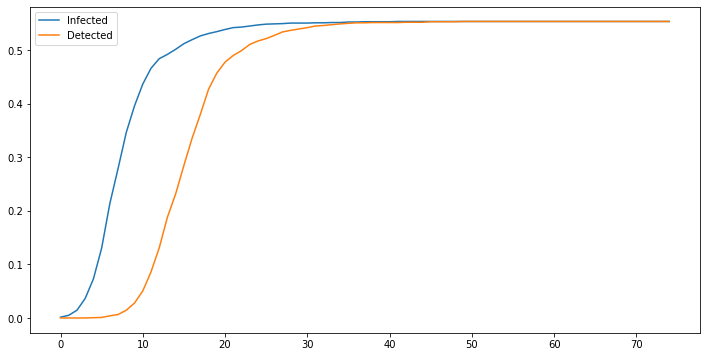

In [8]:
# simulate the covid 19 spread and track its progress
print("social_distancing = False, second_track = True, mass_testing = False")
sim = Covid19(social_distancing = False, second_track = False, mass_testing = False)
track, track_hospital = run_sim(sim, model, plot = True)

plt.figure(figsize = (12,6))
plt.plot(range(days), track, label = "Infected")
plt.plot(range(days), track_hospital, label = "Detected")
plt.legend()
plt.show()

#### **Group 3: social_distancing = True, second_track = False, mass_testing = False**

social_distancing = True, second_track = False, mass_testing = False


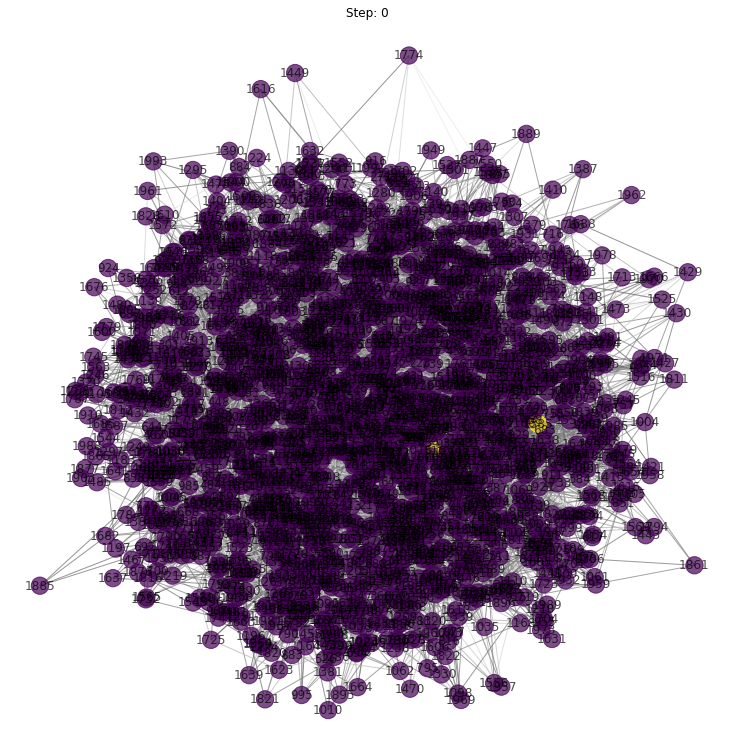

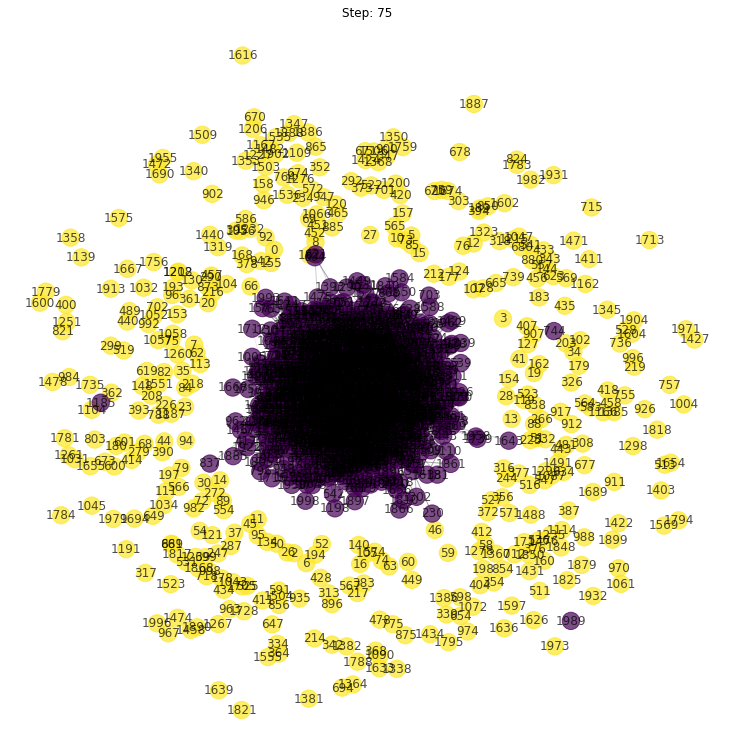

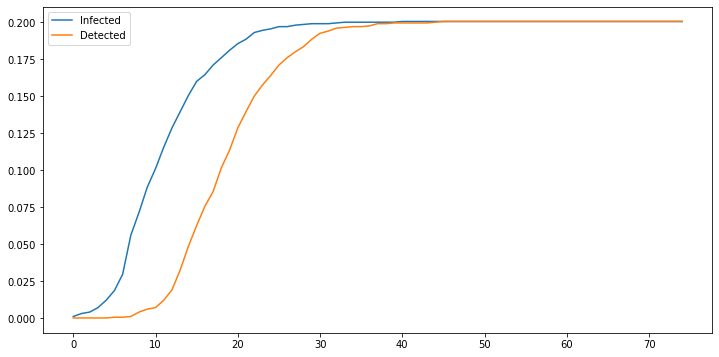

In [9]:
# simulate the covid 19 spread and track its progress
print("social_distancing = True, second_track = False, mass_testing = False")
sim = Covid19(social_distancing = True, second_track = False, mass_testing = False)
track, track_hospital = run_sim(sim, model, plot = True)

plt.figure(figsize = (12,6))
plt.plot(range(days), track, label = "Infected")
plt.plot(range(days), track_hospital, label = "Detected")
plt.legend()
plt.show()

### **Test model on multiple simulations**

In [0]:
# functions to run the model for 8 policies
def run_output(trial = 10, days = days):
  print("Total " + str(trial) + " trials")
  # keep track of the results
  tracks = []
  tracks_hospital = []

  # simulating
  for i in range(trial):
    print("Trial " + str(i) + " is running")

    # initilizing the network model
    model = SocialDynamicsSimulation()
    model.initialize()
    for i in range(30000):
      model.update()

    '''
    Group 0: "social_distancing = False, second_track = False, mass_testing = False",
    Group 1: "social_distancing = False, second_track = False, mass_testing = True ",
    Group 2: "social_distancing = False, second_track = True , mass_testing = False",
    Group 3: "social_distancing = True , second_track = False, mass_testing = False",
    Group 4: "social_distancing = False, second_track = True , mass_testing = True ",
    Group 5: "social_distancing = True , second_track = False, mass_testing = True ",
    Group 6: "social_distancing = True , second_track = True , mass_testing = False",
    Group 7: "social_distancing = True , second_track = True , mass_testing = True ".
    
    '''

    # covid 19 group 0:
    sim1 = Covid19(social_distancing=False, second_track=False, mass_testing = False)
    track_1, track_hospital_1 = run_sim(sim1, model, days)
    
    # covid 19 group 1:
    sim2 = Covid19(social_distancing=False, second_track=False, mass_testing = True)
    track_2, track_hospital_2 = run_sim(sim2, model, days)
    
    # covid 19 group 2:
    sim3 = Covid19(social_distancing=False, second_track=True, mass_testing = False)
    track_3, track_hospital_3 = run_sim(sim3, model, days)
    
    # covid 19 group 3:
    sim4 = Covid19(social_distancing=True, second_track=False, mass_testing = False)
    track_4, track_hospital_4 = run_sim(sim4, model, days)
    
    # covid 19 group 4:
    sim5 = Covid19(social_distancing=False, second_track=True, mass_testing = True)
    track_5, track_hospital_5 = run_sim(sim5, model, days)
    
    # covid 19 group 5:
    sim6 = Covid19(social_distancing=True, second_track=False, mass_testing = True)
    track_6, track_hospital_6 = run_sim(sim6, model, days)
    
    # covid 19 group 6:
    sim7 = Covid19(social_distancing=True, second_track=True, mass_testing = False)
    track_7, track_hospital_7 = run_sim(sim7, model, days)
    
    # covid 19 group 7:
    sim8 = Covid19(social_distancing=True, second_track=True, mass_testing = True)
    track_8, track_hospital_8 = run_sim(sim8, model, days)
    
    # get all the values of different policies
    tracks.append([track_1, track_2, track_3, track_4,
                   track_5, track_6, track_7, track_8])

    tracks_hospital.append([track_hospital_1, track_hospital_2, track_hospital_3, track_hospital_4,
                            track_hospital_5, track_hospital_6, track_hospital_7, track_hospital_8])
  return tracks, tracks_hospital

In [0]:
full_status = ["social_distancing = False, second_track = False, mass_testing = False",
               "social_distancing = False, second_track = False, mass_testing = True ",
               "social_distancing = False, second_track = True , mass_testing = False",
               "social_distancing = True , second_track = False, mass_testing = False",
               "social_distancing = False, second_track = True , mass_testing = True ",
               "social_distancing = True , second_track = False, mass_testing = True ",
               "social_distancing = True , second_track = True , mass_testing = False",
               "social_distancing = True , second_track = True , mass_testing = True "]

In [0]:
tracks, tracks_hospital = run_output(trial = 30)

#### **Save the weight**
Save the values to run afterward and not having to wait 5 hours.

In [0]:
np.save("CS166 FP tracks.npy", tracks)
np.save("CS166 FP tracks hospitals.npy", tracks_hospital)

### **Visulize results**

In [0]:
import os
os.chdir("/content/drive/My Drive/Minerva/CS166/CS166 Covid19")

full_tracks = np.load("CS166 FP tracks.npy")
full_tracks_hospital = np.load("CS166 FP tracks hospitals.npy")

#### **Visulize the pandemic progress: infected vs detected**

social_distancing = False, second_track = False, mass_testing = False


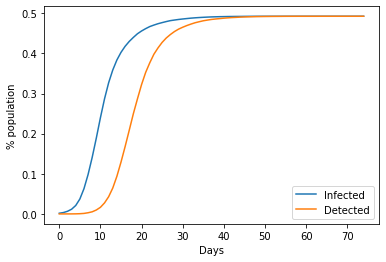

social_distancing = False, second_track = False, mass_testing = True 


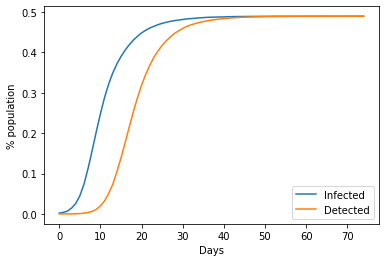

social_distancing = False, second_track = True , mass_testing = False


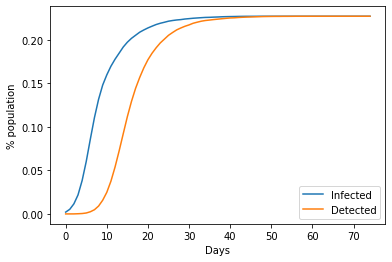

social_distancing = True , second_track = False, mass_testing = False


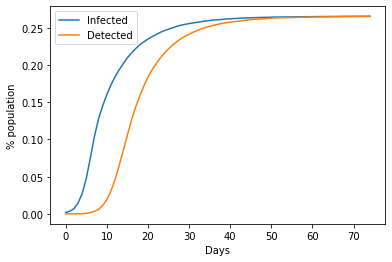

social_distancing = False, second_track = True , mass_testing = True 


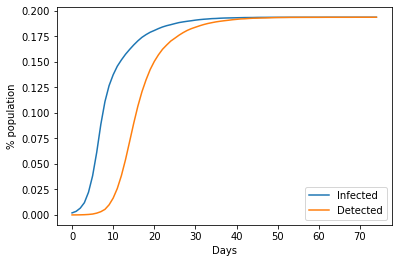

social_distancing = True , second_track = False, mass_testing = True 


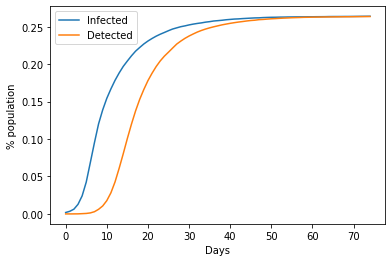

social_distancing = True , second_track = True , mass_testing = False


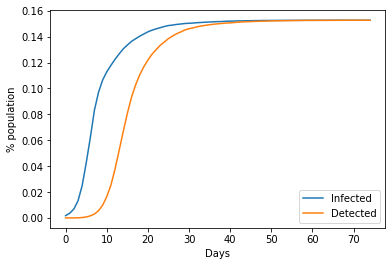

social_distancing = True , second_track = True , mass_testing = True 


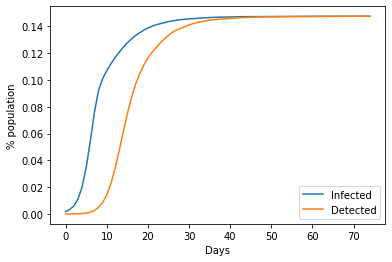

In [14]:
for i in range(8):
  print(full_status[i])
  #plt.figure(figsize = (6,6))
  plt.plot(range(days), np.mean(full_tracks[:,i], axis = 0), label = "Infected")
  plt.plot(range(days), np.mean(full_tracks_hospital[:,i], axis = 0), label = "Detected")
  plt.xlabel("Days")
  plt.ylabel("% population")
  plt.legend()
  plt.show()

#### **Visulize the pandemic progress: infected and its uncertainty**

social_distancing = False, second_track = False, mass_testing = False


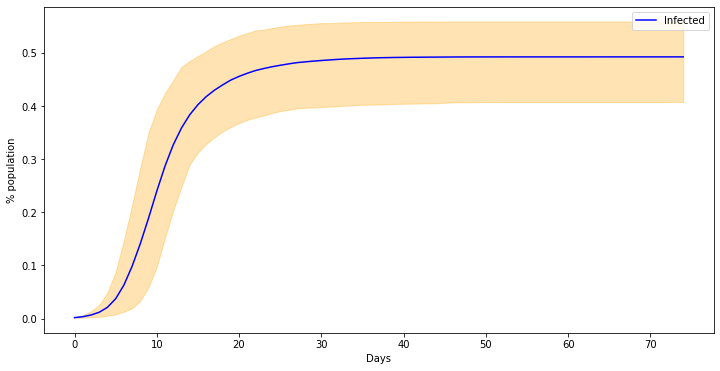

social_distancing = False, second_track = False, mass_testing = True 


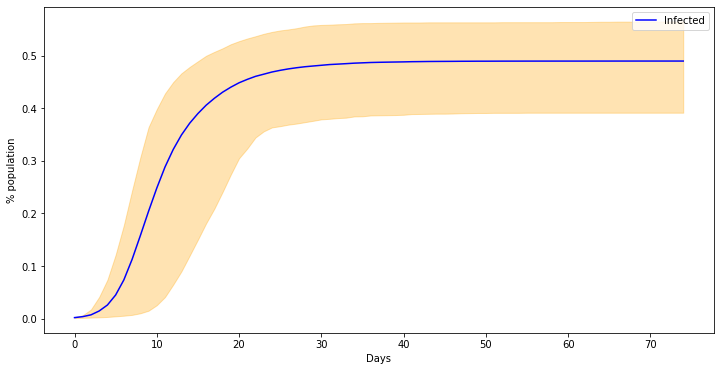

social_distancing = False, second_track = True , mass_testing = False


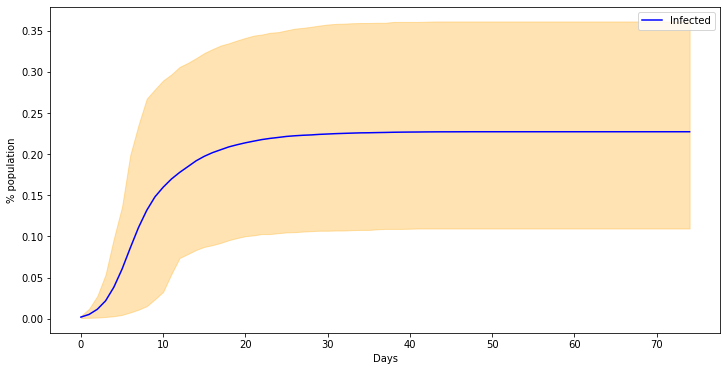

social_distancing = True , second_track = False, mass_testing = False


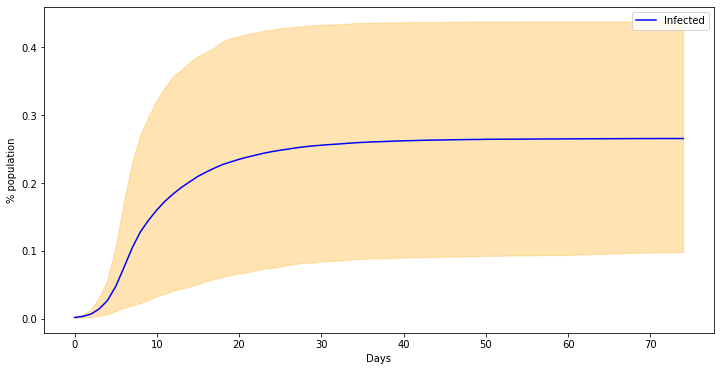

social_distancing = False, second_track = True , mass_testing = True 


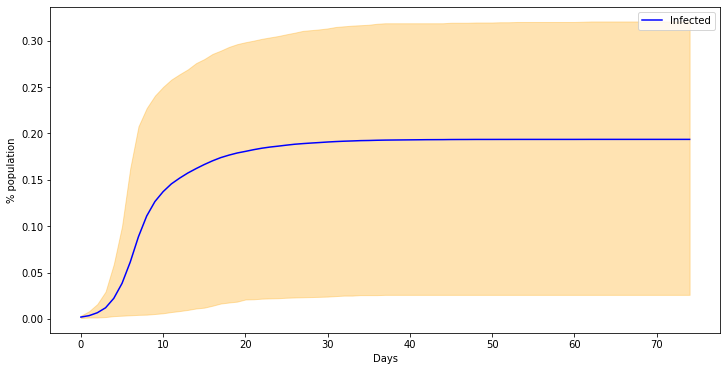

social_distancing = True , second_track = False, mass_testing = True 


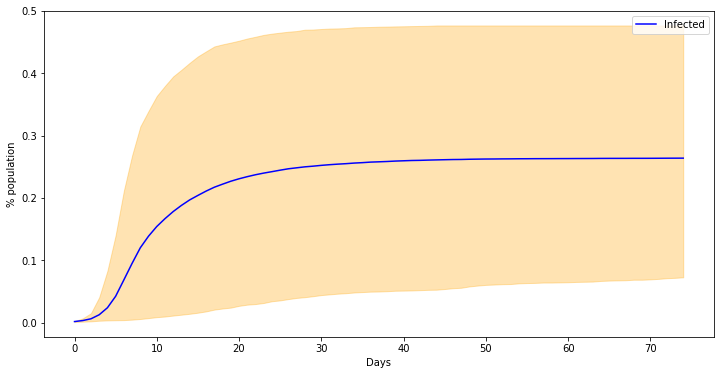

social_distancing = True , second_track = True , mass_testing = False


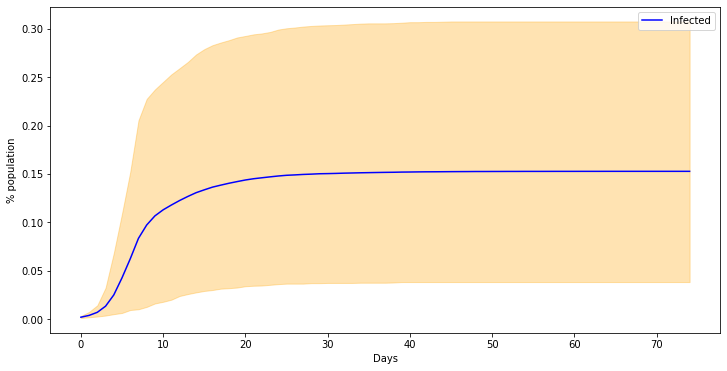

social_distancing = True , second_track = True , mass_testing = True 


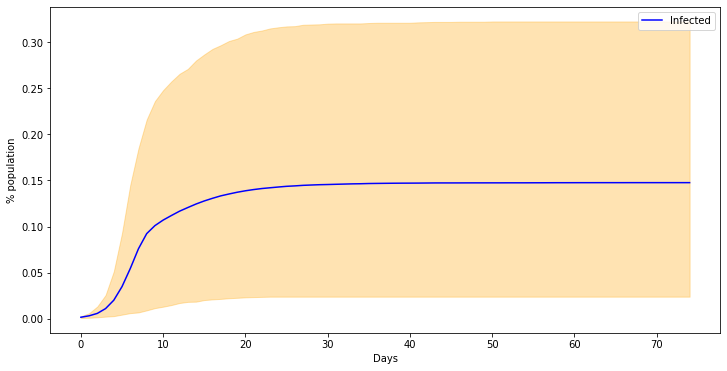

In [15]:
for i in range(8):
  print(full_status[i])
  plt.figure(figsize = (12,6))
  plt.plot(range(days), np.mean(full_tracks[:,i], axis = 0), label = "Infected", color = 'blue')
  x1 = np.quantile(full_tracks[:,i], 0.95, axis = 0)
  x2 = np.quantile(full_tracks[:,i], 0.05, axis = 0)
  plt.fill_between(list(range(days)), x1, x2,
                   facecolor="orange", # The fill color
                   color='orange',       # The outline color
                   alpha=0.3) 
  plt.xlabel("Days")
  plt.ylabel("% population")
  plt.legend()
  plt.show()

#### **Visulize the pandemic progress: detected and its uncertainty**

social_distancing = False, second_track = False, mass_testing = False


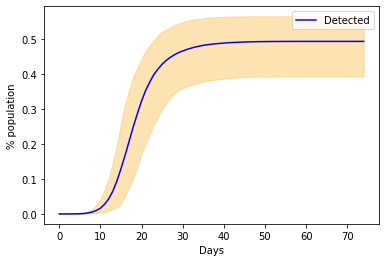

social_distancing = False, second_track = False, mass_testing = True 


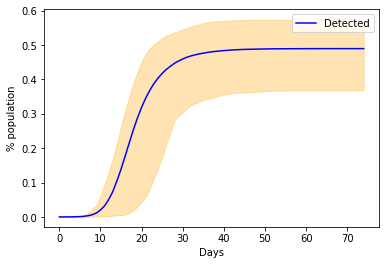

social_distancing = False, second_track = True , mass_testing = False


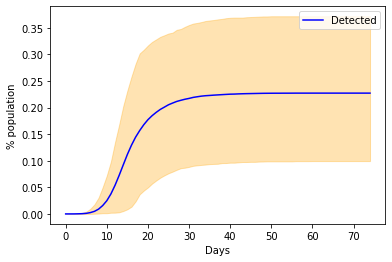

social_distancing = True , second_track = False, mass_testing = False


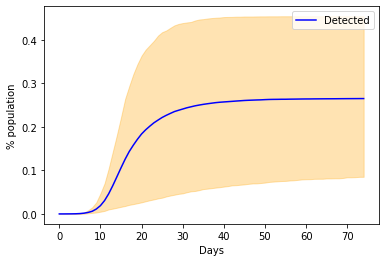

social_distancing = False, second_track = True , mass_testing = True 


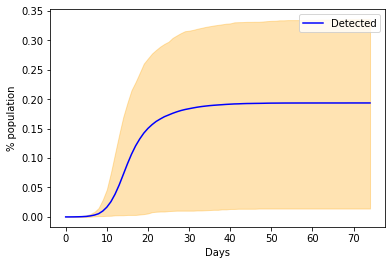

social_distancing = True , second_track = False, mass_testing = True 


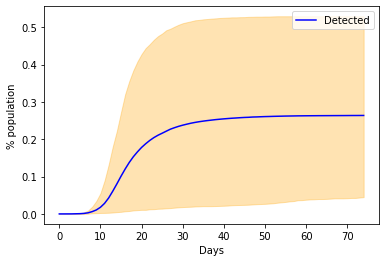

social_distancing = True , second_track = True , mass_testing = False


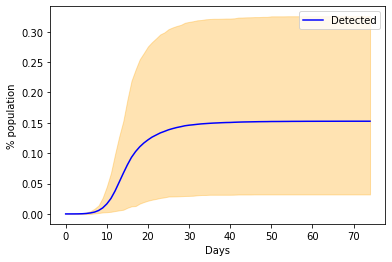

social_distancing = True , second_track = True , mass_testing = True 


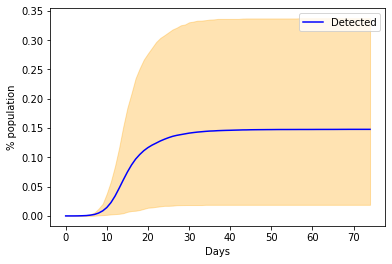

In [16]:
for i in range(8):
  print(full_status[i])
  #plt.figure(figsize = (12,6))
  plt.plot(range(days), np.mean(full_tracks_hospital[:,i], axis = 0), label = "Detected", color = 'blue')
  x1 = np.quantile(full_tracks_hospital[:,i], 0.975, axis = 0)
  x2 = np.quantile(full_tracks_hospital[:,i], 0.025, axis = 0)
  plt.fill_between(list(range(days)), x1, x2,
                   facecolor="orange", # The fill color
                   color='orange',       # The outline color
                   alpha=0.3) 
  plt.xlabel("Days")
  plt.ylabel("% population")
  plt.legend()
  plt.show()

#### **Visulize the histogram of final population infection level in different models**

Mean: 0.4925666666666667
95% confidence interval = [0.39382500000000004, 0.564325]


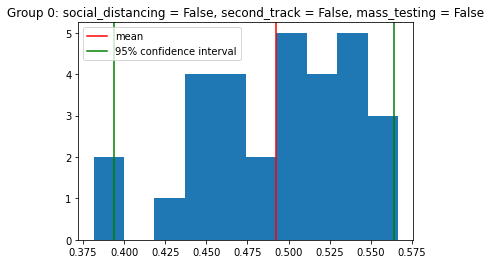


Mean: 0.4895166666666667
95% confidence interval = [0.36836250000000004, 0.5756249999999999]


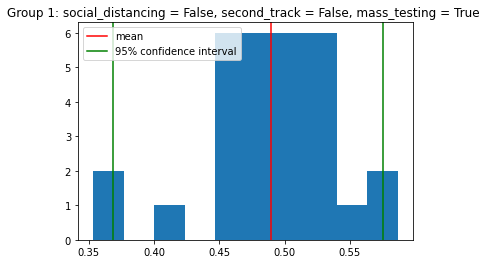


Mean: 0.22721666666666668
95% confidence interval = [0.099375, 0.37183749999999993]


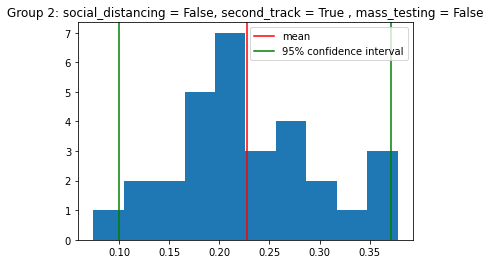


Mean: 0.26541666666666663
95% confidence interval = [0.08852499999999999, 0.45448749999999993]


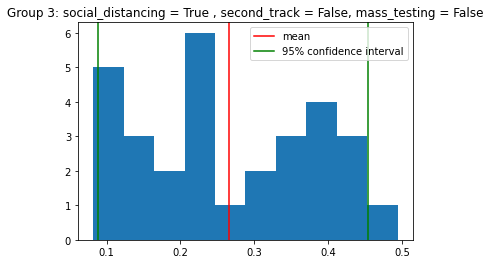


Mean: 0.1935666666666667
95% confidence interval = [0.0142375, 0.33576249999999996]


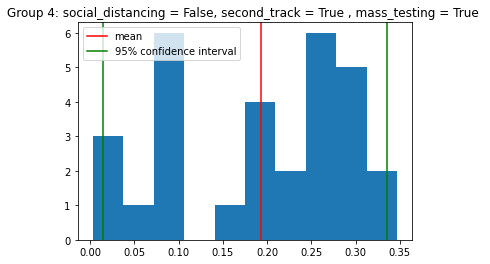


Mean: 0.2639666666666666
95% confidence interval = [0.051475, 0.5292374999999999]


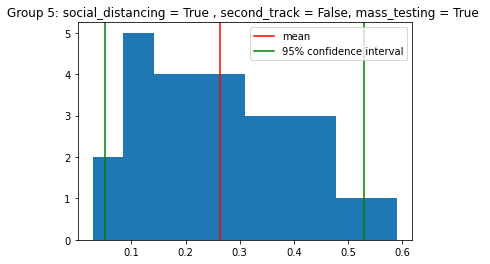


Mean: 0.15263333333333332
95% confidence interval = [0.032087500000000005, 0.32547499999999996]


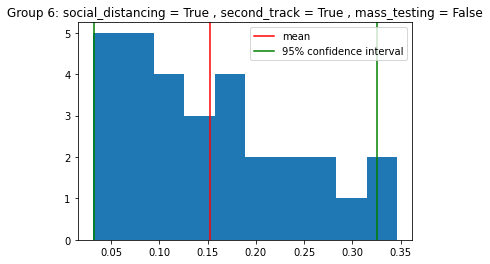


Mean: 0.14763333333333334
95% confidence interval = [0.018925, 0.33707499999999996]


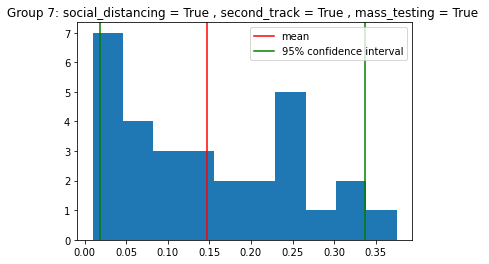

In [17]:
for i in range(8):
  results = [full_tracks[:,i][t][-1] for t in range(30)]
  mean = np.mean(results)
  median, i975, i025 = np.quantile(results, [0.5, 0.975, 0.025])
  print("Mean:", mean)
  print("95% confidence interval = [{}, {}]".format(i025, i975))
  plt.hist(results)
  plt.axvline(mean, color = "red", label = "mean")
  plt.axvline(i975, color = "green", label = "95% confidence interval")
  plt.axvline(i025, color = "green")
  plt.legend()
  plt.title("Group " + str(i) + ": " + full_status[i])
  plt.show()
  print("")



### **Results & Significance analysis**

In [0]:
# final values of different models
final_results = np.array([[full_tracks[:,i][t][-1] for t in range(30)] for i in range(8)])

#### **Reports: Mean, Median, and confidence interval**

In [0]:
report = [["Group " + str(i)] for i in range(8)]
total_mean = sorted([np.mean(final_results[i]) for i in range(8)])
for i in range(8):
  report[i].append(full_status[i][20:25])
  report[i].append(full_status[i][42:47])
  report[i].append(full_status[i][64:])
  report[i].append(np.mean(final_results[i]))
  report[i].append(np.median(final_results[i]))
  report[i].append(np.quantile(final_results[i], 0.025))
  report[i].append(np.quantile(final_results[i], 0.975))
  report[i].append(total_mean.index(np.mean(final_results[i])) + 1)

In [20]:
print(tabulate(report, headers=["Social distancing", "2nd track", "Mass testing", "Mean", "Median", "2.5th percentile", "97.5% percentile", "Ranking"], tablefmt='orgtbl'))

|         | Social distancing   | 2nd track   | Mass testing   |     Mean |   Median |   2.5th percentile |   97.5% percentile |   Ranking |
|---------+---------------------+-------------+----------------+----------+----------+--------------------+--------------------+-----------|
| Group 0 | False               | False       | False          | 0.492567 |  0.503   |          0.393825  |           0.564325 |         8 |
| Group 1 | False               | False       | True           | 0.489517 |  0.49325 |          0.368363  |           0.575625 |         7 |
| Group 2 | False               | True        | False          | 0.227217 |  0.2145  |          0.099375  |           0.371837 |         4 |
| Group 3 | True                | False       | False          | 0.265417 |  0.2365  |          0.088525  |           0.454487 |         6 |
| Group 4 | False               | True        | True           | 0.193567 |  0.209   |          0.0142375 |           0.335762 |         3 |
| Group 5 | T

#### **Reports: T-tests significance**

In [0]:
ttest = [["Group " + str(i)] for i in range(8)]

for i in range(8):
  for j in range(8):
    if i == j:
      ttest[i].append("----")
    else:
      ttest[i].append(format(sts.ttest_ind(final_results[i], final_results[j])[1], '.12f'))

In [22]:
print(tabulate(ttest, headers=["Group " + str(i) for i in range(8)], tablefmt='orgtbl'))

|         | Group 0        | Group 1        | Group 2        | Group 3        | Group 4        | Group 5        | Group 6        | Group 7        |
|---------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------|
| Group 0 | ----           | 0.814840724847 | 0.000000000000 | 0.000000000000 | 0.000000000000 | 0.000000000018 | 0.000000000000 | 0.000000000000 |
| Group 1 | 0.814840724847 | ----           | 0.000000000000 | 0.000000000000 | 0.000000000000 | 0.000000000031 | 0.000000000000 | 0.000000000000 |
| Group 2 | 0.000000000000 | 0.000000000000 | ----           | 0.151215585594 | 0.155539991571 | 0.217353408761 | 0.000997943925 | 0.001463588011 |
| Group 3 | 0.000000000000 | 0.000000000000 | 0.151215585594 | ----           | 0.016609770345 | 0.966330277406 | 0.000139532732 | 0.000184213742 |
| Group 4 | 0.000000000000 | 0.000000000000 | 0.155539991571 | 0.016609770345 | ----           | 0.032036630620 